# Task 2: Idenify **Variety**

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import pandas as pd

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = INFO, 2 = WARNING, 3 = ERROR
import shutil

In [2]:
# Load metadata
meta_df = pd.read_csv("meta_train.csv")

## Re-organize the images

The original images is stored in folders based on their label (disease). Therefore, we have to organize it to folders by variety so that the `tensorflow` dataset can import them into correct classes.

In [3]:
# Step 1: Copy the "train_images" folder to "t2_images"
src_folder = "train_images"
dst_folder = "t2_images"

if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
shutil.copytree(src_folder, dst_folder)

't2_images'

In [4]:
# Step 2: Flatten the folder structure - move all images from subfolders to t2_images root
for root, dirs, files in os.walk(dst_folder):
    for file in files:
        if file.endswith(('.jpg', '.png', '.jpeg')):
            src_file_path = os.path.join(root, file)
            dst_file_path = os.path.join(dst_folder, file)
            if src_file_path != dst_file_path:
                shutil.move(src_file_path, dst_file_path)

In [5]:
# Step 3: Remove any empty subfolders (if exist)
for root, dirs, files in os.walk(dst_folder, topdown=False):
    for d in dirs:
        full_path = os.path.join(root, d)
        if not os.listdir(full_path):
            os.rmdir(full_path)

In [6]:
# Step 4: Move images into subfolders by "variety"
for _, row in meta_df.iterrows():
    image = row['image_id']
    variety = row['variety']
    variety_folder = os.path.join(dst_folder, variety)

    if not os.path.exists(variety_folder):
        os.makedirs(variety_folder)

    src_path = os.path.join(dst_folder, image)
    dst_path = os.path.join(variety_folder, image)

    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)

print("Processing complete!")

Processing complete!


## Main Section

In [7]:
# Constants
ORI_IMAGE_SIZE = (640, 480)  # (width, height)
TARGET_IMAGE_SIZE = (480, 640)  # Use (height, width) for tf.image functions
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 500
N_CLASSES = 10  # adjust to match your actual number

In [8]:
# Step 1: Load dataset (original size)
raw_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "t2_images",
    shuffle=True,
    image_size=ORI_IMAGE_SIZE[::-1],  # (height, width)
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.


In [9]:
# class_names = dataset.class_names
# class_names

In [10]:
# for image_batch, label_batch in dataset.take(1):

#     plt.imshow(image_batch[0].numpy().astype("uint8"))
#     plt.title(class_names[label_batch[0]])
#     plt.axis("off")

In [11]:
# Step 2: Preprocess (pad and normalize)
def preprocess(image, label):
    image = tf.image.resize_with_pad(image, target_height=TARGET_IMAGE_SIZE[0], target_width=TARGET_IMAGE_SIZE[1])
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0, 1]
    return image, label

dataset = raw_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [12]:
# === Step 3: Split into Train / Val / Test ===
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1,
                               shuffle=True, shuffle_buffer_size=50, seed=42):
    assert train_split + val_split + test_split == 1, "Splits must sum to 1"

    dataset_size = dataset.cardinality().numpy()
    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size, seed=seed, reshuffle_each_iteration=False)

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
# === Step 4: Data Augmentation for Training Set Only ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
# === Step 5: Prefetch for All Sets ===
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [15]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# n_classes = 10

# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),
# ])

# model.build(input_shape=input_shape)

In [16]:
input_shape = (480, 640, 3)  # Based on padded image size
n_classes = 10

model = models.Sequential([
    layers.Input(shape=input_shape),  # Start with explicit input layer

    layers.Conv2D(128, kernel_size=3, strides=1, padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=3, padding='valid'),

    layers.Conv2D(64, kernel_size=3, strides=1, padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=3, padding='valid'),

    layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=3, padding='valid'),

    layers.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=3, padding='valid'),

    layers.GlobalAveragePooling2D(),  # Replaces Flatten

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(n_classes, activation='softmax')
])

In [17]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 478, 638, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 159, 212, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 210, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 52, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 70, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 23, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,546 (435.73 KB)

 Trainable params: 111,546 (435.73 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping: stop when validation loss doesn't improve for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# (Optional) Save best model checkpoint
checkpoint = ModelCheckpoint(
    "best_paddy_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6396 - loss: 1.3994
Epoch 1: val_loss improved from inf to 1.21528, saving model to best_paddy_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 2108s 8s/step - accuracy: 0.6397 - loss: 1.3990 - val_accuracy: 0.6807 - val_loss: 1.2153
Epoch 2/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6676 - loss: 1.2530
Epoch 2: val_loss improved from 1.21528 to 1.21022, saving model to best_paddy_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 2137s 8s/step - accuracy: 0.6677 - loss: 1.2528 - val_accuracy: 0.6660 - val_loss: 1.2102
Epoch 3/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6807 - loss: 1.1668
Epoch 3: val_loss improved from 1.21022 to 1.11014, saving model to best_paddy_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 2181s 8s/step - accuracy: 0.6808 - loss: 1.1667 - val_accuracy: 0.6943 - val_loss: 1.1101
Epoch 4/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6989 - loss: 1.1068
Epoch 4: val_loss did not impr

KeyboardInterrupt: 

In [25]:
scores = model.evaluate(test_ds)

34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.6898 - loss: 1.0891


In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

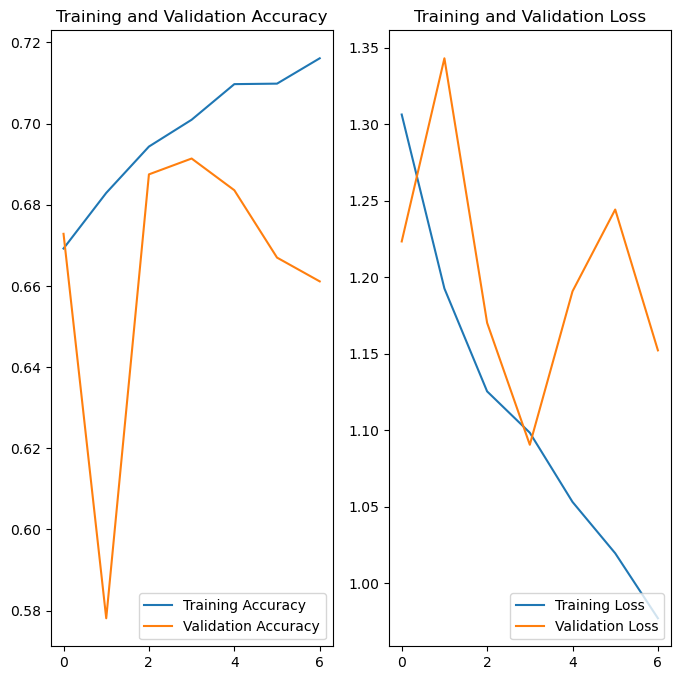

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(7), acc, label='Training Accuracy')
plt.plot(range(7), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(7), loss, label='Training Loss')
plt.plot(range(7), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [31]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

/var/folders/g7/55bmzk2j5mb3_5wz5p1dd2qm0000gn/T/ipykernel_37137/4078180836.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [32]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping]  # or any other callbacks you're using
)

Epoch 1/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 257s 832ms/step - accuracy: 0.6966 - loss: 1.0649 - val_accuracy: 0.7676 - val_loss: 0.7723
Epoch 2/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 211s 739ms/step - accuracy: 0.7830 - loss: 0.6480 - val_accuracy: 0.7959 - val_loss: 0.5994
Epoch 3/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 217s 745ms/step - accuracy: 0.8090 - loss: 0.5523 - val_accuracy: 0.7793 - val_loss: 0.6364
Epoch 4/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 209s 728ms/step - accuracy: 0.8290 - loss: 0.4883 - val_accuracy: 0.8232 - val_loss: 0.5031
Epoch 5/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 211s 739ms/step - accuracy: 0.8509 - loss: 0.4344 - val_accuracy: 0.7998 - val_loss: 0.5673
Epoch 6/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 255s 904ms/step - accuracy: 0.8611 - loss: 0.4001 - val_accuracy: 0.7939 - val_loss: 0.5619
Epoch 7/500
260/260 ━━━━━━━━━━━━━━━━━━━━ 257s 929ms/step - accuracy: 0.8723 - loss: 0.3636 - val_accuracy: 0.8203 - val_loss: 0.5193
